In [1]:
import glob
import tifffile
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from tqdm import tqdm
import rasterio
from rasterio.plot import show
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

warnings.simplefilter('ignore')

In [2]:
train_path =  'train/s2_image/'
mask_path = 'train/mask/'

masks = glob.glob(f'{mask_path}/*')
trains = glob.glob(f'{train_path}/*')
masks.sort()
trains.sort()

In [3]:
train_path =  'train/s2_image/'
mask_path = 'train/mask/'

masks = glob.glob(f'{mask_path}/*')
trains = glob.glob(f'{train_path}/*')
masks.sort()
trains.sort()

In [4]:
path = 'train/s2_image/train_s2_image_90.tif'

In [5]:
ds = rasterio.open(path)

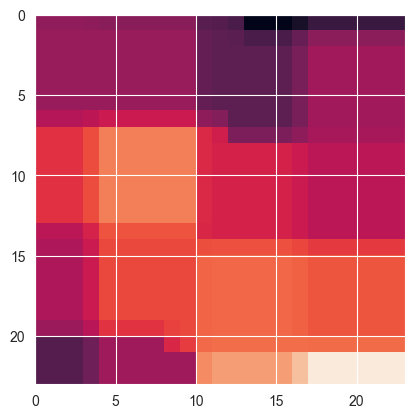

<Axes: >

In [6]:
show((ds, 1))

In [7]:
ds.read(12)

array([[1392.82625192, 1427.61220048, 1549.00970358, 1438.80199676,
        1252.12051541, 1124.77196345, 1002.60303541,  999.54622263,
         960.8109608 ,  947.37164807,  827.65079312,  812.98968406,
         805.83250276,  750.        ,  798.88313184,  936.5       ,
        1064.19387354, 1247.5       , 1247.5       , 1273.78262084,
        1289.        , 1401.57912117, 1433.        ],
       [1406.        , 1441.97007643, 1567.5       , 1455.58072193,
        1266.        , 1125.42344739,  995.5       ,  995.5       ,
         963.57609315,  952.5       ,  834.45578628,  820.        ,
         833.9535181 ,  942.80360943,  994.24010673, 1139.04526549,
        1237.24032955, 1378.20055208, 1378.20055208, 1385.71746365,
        1390.06968158, 1482.65674665, 1508.49783443],
       [1867.12778561, 1804.46942346, 1585.8015697 , 1542.48527093,
        1469.11153825, 1315.48043812, 1173.4917367 , 1173.4917367 ,
        1071.76596351, 1036.47190804,  916.50947509,  901.81878219,
        

In [8]:
ds.indexes

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)

In [9]:
data_list = []
for i in range(len(trains)):
    img = tifffile.imread(trains[i]).astype(float)
    msk = tifffile.imread(masks[i]).astype(float)

    reshaped_img = img.reshape(-1, 12) # (23, 23, 12) -> (23*23, 12)
    flatten_mask = msk.reshape(-1,1)   # (23, 23) -> (23*23, 1)

    is_train     = 1
    if i % 5 == 0:  is_train     = 0
    is_train_image = np.full((reshaped_img.shape[0], 1), is_train)

    combine_data = np.hstack((reshaped_img, flatten_mask))
    combine_data = np.hstack((combine_data, is_train_image))

    data_list.append(combine_data)

data_list = np.vstack(data_list)

In [10]:
df = pd.DataFrame(data=data_list, columns= ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11','B12', 'Mask', 'is_train'])
df

,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,Mask,is_train
0,265.800583,279.066472,488.098252,331.572300,817.002914,2400.280728,3084.914212,3236.613360,3332.798479,3251.691757,1598.907575,818.413402,0.0,0.0
1,265.800583,271.067287,472.501621,322.083156,817.002914,2400.280728,3084.914212,3188.111508,3332.798479,3251.691757,1598.907575,818.413402,0.0,0.0
2,265.800583,240.942322,424.775329,279.931718,784.908433,2322.216009,2998.675982,2906.248048,3251.978778,3251.691757,1549.296809,798.364396,0.0,0.0
3,265.800583,222.820502,411.740847,245.060190,737.346930,2206.530216,2870.877686,2640.218320,3132.210318,3251.691757,1475.777544,768.653340,0.0,0.0
4,378.735906,229.331874,434.090056,254.714547,782.884060,2226.587592,2840.185718,2651.574272,3084.218565,3341.757199,1562.631939,809.818550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133567,1166.000000,1049.347260,1190.897532,1254.509945,1365.000000,1379.000000,1468.000000,1463.018392,1461.000000,1490.000000,2027.000000,1859.000000,0.0,0.0
1133568,1166.000000,1090.473893,1243.402564,1362.630769,1365.000000,1379.000000,1468.000000,1572.583217,1461.000000,1490.000000,2027.000000,1859.000000,0.0,0.0
1133569,1089.344375,1097.961592,1251.727616,1360.179232,1399.362866,1489.137392,1583.130287,1621.304781,1591.402672,1639.199454,2009.671717,1797.029361,0.0,0.0
1133570,905.000000,1018.380712,1222.829764,1265.576354,1482.000000,1754.000000,1860.000000,1952.131222,1905.000000,1998.000000,1968.000000,1648.000000,0.0,0.0


In [11]:
df['is_train'].value_counts()

1.0    905863
0.0    227709
Name: is_train, dtype: int64

In [12]:
X = df.iloc[:,0:12]  #independent columns
y = df.iloc[:,-2]    #target column i.e price range
y

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1133567    0.0
1133568    0.0
1133569    0.0
1133570    0.0
1133571    0.0
Name: Mask, Length: 1133572, dtype: float64


from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

import seaborn as sns
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10, 'Score'))  #print 10 best features

In [13]:
#df = df[['B6' ,'B12', 'B9', 'B7', 'B2', 'B8', 'B11', 'Mask']]
#df

In [14]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#data = df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11','B12']]


In [15]:
new_df = df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11','B12']]

new_df['Mask'] = df['Mask']


0.0    1027487
1.0     106085
Name: Mask, dtype: int64


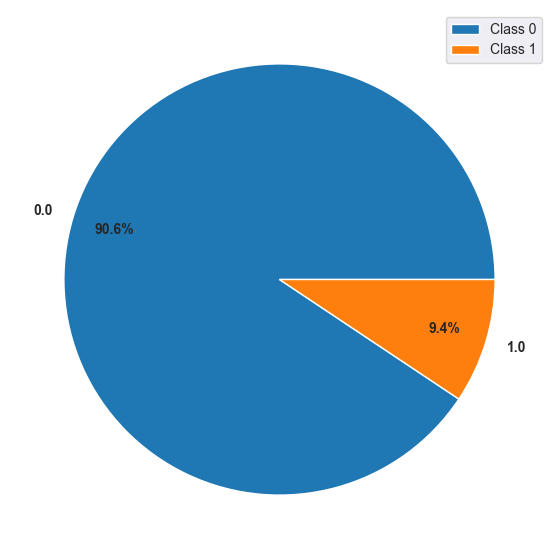

In [16]:
import matplotlib.pyplot as plt
figure1 = plt.figure(figsize=(10,7), facecolor='w')
plt.axis('off')
x = y.value_counts()
print(x)

plt.pie(x, labels=[i for i in x.index], autopct="%.1f%%", pctdistance=0.8,
        textprops={'fontsize': 10, 'fontweight': 'bold'})
plt.legend(['Class 0', 'Class 1'])
plt.show()

In [17]:
new_df.loc[:,'Mask']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1133567    0.0
1133568    0.0
1133569    0.0
1133570    0.0
1133571    0.0
Name: Mask, Length: 1133572, dtype: float64

In [18]:
X = new_df.loc[:,'B1':'B12']
y = new_df.loc[:,'Mask']


In [19]:
import xgboost as xgb
from optuna.integration import CatBoostPruningCallback
from sklearn.model_selection import RepeatedKFold
import optuna
from optuna import create_study

In [20]:
#X_train.reset_index(drop = True, inplace = True)
##y_train.reset_index(drop = True, inplace = True)

In [21]:
#y_train.value_counts()

sm = SMOTE(random_state=1945)
X,y = sm.fit_resample(X, y)
print(X.shape)
print(y.shape)


logloss = []

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'gamma': 5
}
for train_index, test_index in tqdm(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

    # Create the DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)

    dtest = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain,
                      evals=[(dtest, 'Validation')],

                      verbose_eval=False)

    # Predict on the test set
    y_pred = model.predict(dtest)
    pred_labels = np.rint(y_pred)
    print(y_test.shape)
    print(y_pred.shape)
    print(y_pred[:5])

In [22]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred), average='weighted')
    return 'f1_err', err

In [68]:
from sklearn.metrics import log_loss
from tqdm import tqdm
N_TRIALS = 100
RS = 0  # random state
N_JOBS = -1  # number of parallel threads

# repeated K-folds
N_SPLITS = 5
N_REPEATS = 2

# Optuna
MULTIVARIATE = True




def objective(
        trial,
        X,
        y,
        random_state=0,
        n_splits=N_SPLITS ,
        n_repeats=N_REPEATS,
        n_jobs=-1,
        early_stopping_rounds=20,
):
    # Catboost parameters
    param = {
        'objective': 'binary:logistic',
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param['subsample'] = trial.suggest_float('subsample', 0.50, 1)
        param['min_child_weight'] = trial.suggest_int('min_child_weight', 5, 10)
        param['colsample_bytree']= trial.suggest_float('colsample_bytree', 0.50, 1)
        param['max_depth']= trial.suggest_int('max_depth', 1, 20)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    oversample = RandomUnderSampler(sampling_strategy="auto")
    X,y = oversample.fit_resample(X, y)


    f1_scores = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in tqdm(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create the DMatrix for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)


        early_stop = xgb.callback.EarlyStopping(rounds=20,min_delta=1e-3,
                                                data_name='Train')

        # Train the model with the current hyperparameters
        model = xgb.train(param, dtrain,
                          evals=[(dtrain, 'Train'), (dtest, 'Valid')],
                          callbacks=[early_stop],
                          feval=f1_eval,
                          verbose_eval=False)

        # Predict on the test set
        y_pred = model.predict(dtest)

        # Convert probabilities to binary predictions

        pred_labels = [1 if pred >= 0.6 else 0 for pred in y_pred]

        ll= f1_score(y_test, pred_labels, average='binary')
        f1_scores.append(ll)

    mean_of_f1_scores = sum(f1_scores) / len(f1_scores)
    print("mean_of_f1_scores :", mean_of_f1_scores)
    return mean_of_f1_scores

In [69]:
def prep_data(X,y):
    study = optuna.create_study(direction="maximize",pruner=optuna.pruners.MedianPruner(),sampler=optuna.samplers.TPESampler(seed=10))

    study.optimize(lambda trial :objective(trial,X, y,
                                           random_state=RS,
                                           n_splits=N_SPLITS,
                                           n_repeats=N_REPEATS,
                                           n_jobs=-1,
                                           ),
                   n_trials=N_TRIALS,
                   n_jobs=-1,
                   )

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    best_par = study.best_params
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    best_params = trial.params
    best_params['objective'] = 'binary:logistic'


    return best_par

In [70]:
#Apply StandardScaler to the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Convert the scaled data back to pandas DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

In [71]:
def final_class(X,y ):

    best_param=prep_data(X,y)
    return best_param

In [ ]:
best_params = final_class(X, y)

[I 2023-11-27 14:17:36,479] A new study created in memory with name: no-name-a24f6170-5710-4045-8984-4ba4b978ce82
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]


0it [00:00, ?it/s]




0it [00:00, ?it/s]



0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]







0it [00:00, ?it/s]








0it [00:00, ?it/s]









0it [00:00, ?it/s]










0it [00:00, ?it/s]











0it [00:00, ?it/s]













0it [00:00, ?it/s]














0it [00:00, ?it/s]












0it [00:00, ?it/s]




1it [00:06,  6.24s/it]



1it [00:06,  6.69s/it]










1it [00:07,  7.78s/it]






1it [00:09,  9.39s/it]











1it [00:09,  9.47s/it]

1it [00:10, 10.82s/it]














1it [00:11, 11.21s/it]




2it [00:13,  6.82s/it]



2it [00:14,  7.12s/it]












1it [00:14, 14.93s/it]










2it [00:16,  8.22s/it]











2it [00:18,  9.30s/it]






1it [00:20, 20.07s/it]
1it [00:21, 21.65s/it]




3it [00:22,  7.82s/it]

2it [00:23, 11.60s/it]



3it [0

mean_of_f1_scores : 0.0







0it [00:00, ?it/s]



5it [00:42,  8.44s/it]
[I 2023-11-27 14:18:22,042] Trial 9 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'learning_rate': 0.03581252461363502, 'lambda': 0.9339622391756112, 'alpha': 9.1422307545581e-05}. Best is trial 2 with value: 0.0.












4it [00:42, 10.95s/it]

mean_of_f1_scores : 0.0


2it [00:43, 22.20s/it]



0it [00:00, ?it/s]






4it [00:44, 11.70s/it]
2it [00:46, 23.56s/it]










5it [00:48,  9.77s/it]
[I 2023-11-27 14:18:28,903] Trial 15 finished with value: 0.8141583062501961 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05217133251179201, 'lambda': 5.448830666241825e-06, 'alpha': 0.008649108047573547, 'subsample': 0.5700884037786847, 'min_child_weight': 8, 'colsample_bytree': 0.9149269465249408, 'max_depth': 3, 'eta': 0.002785619561968193, 'gamma': 1.585976515953744e-07, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 0.8141583062501961.


mean_of_f1_scores : 0.8141583062501961













0it [00:00, ?it/s]

4it [00:55, 14.91s/it]











5it [00:57, 11.54s/it]
[I 2023-11-27 14:18:37,903] Trial 12 finished with value: 0.8374914619093363 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07890014953419548, 'lambda': 3.5223123337139924e-05, 'alpha': 0.005767034463959711, 'subsample': 0.6679046269259574, 'min_child_weight': 6, 'colsample_bytree': 0.6058634071503788, 'max_depth': 4, 'eta': 0.000734921634870521, 'gamma': 1.137717656020629e-06, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 0.8374914619093363.


mean_of_f1_scores : 0.8374914619093363

















4it [00:58, 15.85s/it]












3it [00:58, 20.78s/it]











0it [00:00, ?it/s]





2it [01:01, 31.61s/it]






5it [01:03, 12.68s/it]
[I 2023-11-27 14:18:43,310] Trial 3 finished with value: 0.8669488555508789 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07985403278586715, 'lambda': 0.0007966440613389532, 'alpha': 6.739413838674566e-07, 'subsample': 0.5225066540550038, 'min_child_weight': 8, 'colsample_bytree': 0.5834593280864784, 'max_depth': 5, 'eta': 0.0061719605525467165, 'gamma': 7.095483348853314e-08, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 0.8669488555508789.


mean_of_f1_scores : 0.8669488555508789









0it [00:00, ?it/s]










1it [00:14, 14.80s/it]













2it [01:09, 36.35s/it]


2it [01:14, 39.73s/it]



1it [00:32, 32.52s/it]









2it [01:17, 40.71s/it]






1it [00:13, 13.25s/it]










2it [00:27, 13.57s/it]




1it [00:37, 37.09s/it]

5it [01:20, 16.16s/it]
[I 2023-11-27 14:19:00,574] Trial 11 finished with value: 0.8270232112309891 and parameters: {'booster': 'gbtree', 'learning_rate': 0.03549556686594638, 'lambda': 2.1749629847651976e-06, 'alpha': 0.00014749042877317112, 'subsample': 0.7297831192045225, 'min_child_weight': 6, 'colsample_bytree': 0.9162323627820104, 'max_depth': 6, 'eta': 3.900355580164298e-05, 'gamma': 7.701305691806017e-05, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.8669488555508789.


mean_of_f1_scores : 0.8270232112309891




0it [00:00, ?it/s]














5it [01:22, 16.55s/it]
[I 2023-11-27 14:19:02,984] Trial 10 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'learning_rate': 0.022688991798627305, 'lambda': 1.6152116404389023e-06, 'alpha': 2.6711261056593777e-06, 'subsample': 0.8903465855766501, 'min_child_weight': 5, 'colsample_bytree': 0.7470857329239082, 'max_depth': 6, 'eta': 2.893170602408232e-06, 'gamma': 0.8357564276302917, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 0.8669488555508789.


mean_of_f1_scores : 0.0


3it [01:23, 30.42s/it]







2it [01:24, 43.87s/it]








2it [01:24, 43.86s/it]














0it [00:00, ?it/s]












4it [01:25, 23.18s/it]










3it [00:37, 11.85s/it]






2it [00:24, 11.82s/it]
3it [01:34, 34.70s/it]



2it [00:52, 25.16s/it]

1it [00:16, 16.16s/it]










4it [00:47, 11.06s/it]






3it [00:33, 10.86s/it]




2it [01:00, 28.85s/it]





3it [01:44, 36.98s/it]










5it [00:54, 10.97s/it]
[I 2023-11-27 14:19:25,893] Trial 18 finished with value: 0.27083560624970077 and parameters: {'booster': 'gblinear', 'learning_rate': 0.09146831387737862, 'lambda': 1.3873102651119595e-05, 'alpha': 6.439149802788547e-08}. Best is trial 3 with value: 0.8669488555508789.


mean_of_f1_scores : 0.27083560624970077

















1it [00:21, 21.87s/it]






4it [00:42,  9.85s/it]













3it [01:47, 36.71s/it]










0it [00:00, ?it/s]











1it [00:47, 47.88s/it]












5it [01:48, 21.68s/it]
[I 2023-11-27 14:19:28,717] Trial 14 finished with value: 0.4164656132516874 and parameters: {'booster': 'dart', 'learning_rate': 0.027055673641083276, 'lambda': 0.0011797078847389766, 'alpha': 1.722104775687434e-06, 'subsample': 0.5596554566326641, 'min_child_weight': 9, 'colsample_bytree': 0.5594621700169236, 'max_depth': 5, 'eta': 0.00043220046320327195, 'gamma': 2.271366932066466e-07, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.052500381813959954, 'skip_drop': 0.6365859907474852}. Best is trial 3 with value: 0.8669488555508789.


mean_of_f1_scores : 0.4164656132516874




2it [00:28, 13.95s/it]












0it [00:00, ?it/s]


4it [01:51, 29.46s/it]









3it [01:52, 38.01s/it]



3it [01:09, 21.52s/it]






5it [00:51, 10.30s/it]
[I 2023-11-27 14:19:36,695] Trial 20 finished with value: 0.05308884923466878 and parameters: {'booster': 'gblinear', 'learning_rate': 0.06946578375711619, 'lambda': 0.0004440629595310216, 'alpha': 5.769079843012322e-06}. Best is trial 3 with value: 0.8669488555508789.


mean_of_f1_scores : 0.05308884923466878









0it [00:00, ?it/s]












1it [00:08,  8.27s/it]
4it [02:00, 31.24s/it]




3it [01:19, 24.39s/it]

3it [00:40, 12.93s/it]














2it [00:39, 19.60s/it]







3it [02:04, 42.28s/it]








3it [02:06, 42.96s/it]












2it [00:16,  8.16s/it]



4it [01:24, 18.87s/it]





4it [02:10, 32.73s/it]

4it [00:52, 12.55s/it]












5it [02:16, 27.24s/it]
[I 2023-11-27 14:19:55,883] Trial 0 finished with value: 0.919247781084235 and parameters: {'booster': 'gbtree', 'learning_rate': 0.09408343389812125, 'lambda': 7.778605992527969e-07, 'alpha': 3.3023874352401187e-07, 'subsample': 0.5007387473548379, 'min_child_weight': 8, 'colsample_bytree': 0.7345119367530865, 'max_depth': 16, 'eta': 2.9582389728538706e-07, 'gamma': 0.007188778691368364, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.919247781084235.


mean_of_f1_scores : 0.919247781084235
















0it [00:00, ?it/s]/it]










1it [00:31, 31.90s/it]


4it [02:20, 34.86s/it]











2it [01:20, 39.17s/it]




4it [01:40, 22.96s/it]









4it [02:22, 35.08s/it]














3it [00:58, 19.20s/it]



5it [01:40, 20.17s/it]
[I 2023-11-27 14:20:04,636] Trial 17 finished with value: 0.0 and parameters: {'booster': 'dart', 'learning_rate': 0.0114372903035499, 'lambda': 6.400491051037757e-06, 'alpha': 0.009768988004679747, 'subsample': 0.6657782610491217, 'min_child_weight': 10, 'colsample_bytree': 0.5023965406412505, 'max_depth': 2, 'eta': 0.00262256068835415, 'gamma': 1.2581794831946409e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.018014500834389185, 'skip_drop': 3.947486726448631e-06}. Best is trial 0 with value: 0.919247781084235.


mean_of_f1_scores : 0.0















4it [00:35,  9.09s/it]



0it [00:00, ?it/s]
5it [02:28, 29.64s/it]
[I 2023-11-27 14:20:07,999] Trial 1 finished with value: 0.9056011228663404 and parameters: {'booster': 'dart', 'learning_rate': 0.08628825973547137, 'lambda': 4.856395783889725e-06, 'alpha': 0.018228652042690092, 'subsample': 0.5268351556770563, 'min_child_weight': 8, 'colsample_bytree': 0.5036075400417017, 'max_depth': 15, 'eta': 0.33141290793883327, 'gamma': 1.7332726786766658e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.0576003175370417e-07, 'skip_drop': 0.0883764686068212}. Best is trial 0 with value: 0.919247781084235.







1it [00:29, 29.97s/it]

mean_of_f1_scores : 0.9056011228663404




5it [01:06, 13.31s/it]
[I 2023-11-27 14:20:08,547] Trial 21 finished with value: 0.8365413654804327 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05570113465491822, 'lambda': 4.121488741555002e-06, 'alpha': 3.855527511216219e-05, 'subsample': 0.7575105737476416, 'min_child_weight': 6, 'colsample_bytree': 0.6135361847016465, 'max_depth': 5, 'eta': 0.0007325107237202407, 'gamma': 6.918904483176185e-07, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.919247781084235.


mean_of_f1_scores : 0.8365413654804327



0it [00:00, ?it/s]

0it [00:00, ?it/s]












5it [00:43,  8.74s/it]
[I 2023-11-27 14:20:14,228] Trial 24 finished with value: 0.27174474614216204 and parameters: {'booster': 'gblinear', 'learning_rate': 0.09119414099995936, 'lambda': 2.9244237018222762e-08, 'alpha': 2.90054089864293e-08}. Best is trial 0 with value: 0.919247781084235.


mean_of_f1_scores : 0.27174474614216204















0it [00:00, ?it/s]







4it [02:39, 39.16s/it]





5it [02:40, 31.49s/it]




5it [01:58, 23.65s/it]
5it [02:40, 32.08s/it]
[I 2023-11-27 14:20:20,292] Trial 16 finished with value: 0.0 and parameters: {'booster': 'gbtree', 'learning_rate': 0.003589800132205061, 'lambda': 0.000367835575833072, 'alpha': 1.6389925537778604e-07, 'subsample': 0.7844991309593302, 'min_child_weight': 8, 'colsample_bytree': 0.5956232102659247, 'max_depth': 11, 'eta': 0.1151345585265247, 'gamma': 2.342379122597723e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.919247781084235.
[I 2023-11-27 14:20:20,298] Trial 13 finished with value: 0.8885154346991218 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05125702383922245, 'lambda': 0.00023424808362065906, 'alpha': 1.585055855101807e-05, 'subsample': 0.6421524479712694, 'min_child_weight': 10, 'colsample_bytree': 0.6819067798040503, 'max_depth': 20, 'eta': 1.5821107034789487e-08, 'gamma': 0.24482779286633588, 'grow_policy':

mean_of_f1_scores : 0.0
mean_of_f1_scores : 0.8885154346991218

















4it [01:17, 18.98s/it]




0it [00:00, ?it/s]





1it [00:25, 25.29s/it][A








4it [02:43, 40.58s/it]













5it [02:45, 33.03s/it]
[I 2023-11-27 14:20:25,389] Trial 6 finished with value: 0.9020941241759763 and parameters: {'booster': 'dart', 'learning_rate': 0.04731451929021272, 'lambda': 0.008811316863915312, 'alpha': 1.6723510458299147e-06, 'subsample': 0.687402725099146, 'min_child_weight': 10, 'colsample_bytree': 0.7799765641777248, 'max_depth': 14, 'eta': 1.95522119616508e-06, 'gamma': 0.0022742224510623236, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 8.873336073799589e-06, 'skip_drop': 0.2008730890631351}. Best is trial 0 with value: 0.919247781084235.


mean_of_f1_scores : 0.9020941241759763
















0it [00:00, ?it/s]










2it [01:02, 31.20s/it]


5it [02:51, 34.33s/it]
[I 2023-11-27 14:20:31,445] Trial 8 finished with value: 0.9055948221190897 and parameters: {'booster': 'dart', 'learning_rate': 0.09206136482933983, 'lambda': 0.053053666848085476, 'alpha': 0.002874189402550443, 'subsample': 0.7283405843433151, 'min_child_weight': 8, 'colsample_bytree': 0.6244450475210253, 'max_depth': 19, 'eta': 1.2928495837709128e-06, 'gamma': 0.0008991998151689696, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.07154725683142642, 'skip_drop': 0.00018315244687889238}. Best is trial 0 with value: 0.919247781084235.


mean_of_f1_scores : 0.9055948221190897






1it [00:25, 25.57s/it]


0it [00:00, ?it/s]









5it [02:54, 34.86s/it]
[I 2023-11-27 14:20:34,245] Trial 5 finished with value: 0.9248248177410169 and parameters: {'booster': 'dart', 'learning_rate': 0.09746768357114355, 'lambda': 1.3291410032984992e-07, 'alpha': 0.0020300043292796745, 'subsample': 0.8146156305158845, 'min_child_weight': 9, 'colsample_bytree': 0.7760493724389232, 'max_depth': 16, 'eta': 0.00011354951914600772, 'gamma': 0.00013395280721208825, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.000993433636880529, 'skip_drop': 0.010286847692015795}. Best is trial 5 with value: 0.9248248177410169.


mean_of_f1_scores : 0.9248248177410169














3it [01:54, 36.49s/it]









0it [00:00, ?it/s]






2it [00:59, 29.55s/it]














5it [01:34, 18.83s/it]
[I 2023-11-27 14:20:38,874] Trial 22 finished with value: 0.8803369213442085 and parameters: {'booster': 'dart', 'learning_rate': 0.09766211511649237, 'lambda': 0.0006716250164830977, 'alpha': 0.3384603591696164, 'subsample': 0.7231553823269873, 'min_child_weight': 10, 'colsample_bytree': 0.5842912194898482, 'max_depth': 5, 'eta': 0.5523795048403757, 'gamma': 9.719573379745064e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.047228772652708605, 'skip_drop': 0.02403924023810905}. Best is trial 5 with value: 0.9248248177410169.


mean_of_f1_scores : 0.8803369213442085

















0it [00:00, ?it/s]
1it [00:31, 31.91s/it]

1it [00:31, 31.39s/it]












2it [00:51, 25.56s/it]





1it [00:29, 29.93s/it]




1it [00:31, 31.47s/it]













1it [00:28, 28.33s/it]







5it [03:16, 39.34s/it]
[I 2023-11-27 14:20:56,624] Trial 4 finished with value: 0.893413694801634 and parameters: {'booster': 'dart', 'learning_rate': 0.036111865023992794, 'lambda': 2.692838376318584e-07, 'alpha': 0.016535921418072287, 'subsample': 0.837468150799545, 'min_child_weight': 5, 'colsample_bytree': 0.9464771582393279, 'max_depth': 17, 'eta': 1.6252430527531762e-06, 'gamma': 1.7025269334090876e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.5644662179248553e-08, 'skip_drop': 0.00037545651266639293}. Best is trial 5 with value: 0.9248248177410169.


mean_of_f1_scores : 0.893413694801634










0it [00:00, ?it/s]



2it [00:53, 26.90s/it]


1it [00:28, 28.56s/it]








5it [03:21, 40.39s/it]
[I 2023-11-27 14:21:01,889] Trial 7 finished with value: 0.0 and parameters: {'booster': 'dart', 'learning_rate': 0.004958981207541942, 'lambda': 5.1148357353663966e-05, 'alpha': 5.146440809028717e-06, 'subsample': 0.5493166268920675, 'min_child_weight': 7, 'colsample_bytree': 0.9427503072492694, 'max_depth': 19, 'eta': 9.00510097234523e-08, 'gamma': 2.841022826647092e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.4001185427682064, 'skip_drop': 1.2992330555495742e-08}. Best is trial 5 with value: 0.9248248177410169.


mean_of_f1_scores : 0.0













3it [01:34, 31.42s/it]








0it [00:00, ?it/s]






3it [01:30, 30.15s/it]









1it [00:33, 33.55s/it]











4it [02:31, 36.61s/it]














1it [00:33, 33.26s/it]












2it [00:58, 29.38s/it]

2it [01:06, 33.44s/it]
3it [01:20, 27.16s/it]





2it [01:01, 30.88s/it]













2it [00:58, 29.64s/it]




2it [01:07, 34.13s/it]



3it [01:23, 28.35s/it]


2it [00:58, 29.48s/it]







1it [00:33, 33.48s/it]








1it [00:33, 33.09s/it]










4it [02:08, 32.65s/it]






4it [02:04, 31.85s/it]









2it [01:08, 34.60s/it]












4it [01:50, 28.31s/it]














2it [01:09, 34.84s/it]











5it [03:09, 37.88s/it]
[I 2023-11-27 14:21:49,939] Trial 19 finished with value: 0.9028580659765936 and parameters: {'booster': 'dart', 'learning_rate': 0.06121782317800433, 'lambda': 3.774976262861235e-07, 'alpha': 0.0011111251437342764, 'subsample': 0.9299295254590205, 'min_child_weight': 10, 'colsample_bytree': 0.7463442949769337, 'max_dept

mean_of_f1_scores : 0.9028580659765936














0it [00:00, ?it/s]

3it [01:41, 34.47s/it]
3it [01:43, 34.88s/it]













3it [01:28, 29.72s/it]





3it [01:34, 31.87s/it]



4it [01:51, 28.33s/it]


3it [01:28, 29.61s/it]




3it [01:41, 34.15s/it]







2it [01:06, 33.35s/it]








2it [01:05, 32.73s/it]










5it [02:41, 32.27s/it]
[I 2023-11-27 14:22:09,556] Trial 23 finished with value: 0.0 and parameters: {'booster': 'dart', 'learning_rate': 0.008262168669918822, 'lambda': 0.01745541880456003, 'alpha': 0.0017106635167721998, 'subsample': 0.7648623888808386, 'min_child_weight': 6, 'colsample_bytree': 0.6024726268157993, 'max_depth': 16, 'eta': 2.7322687350517744e-08, 'gamma': 1.836598305323367e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0014178704938272496, 'skip_drop': 1.0924866779655643e-08}. Best is trial 5 with value: 0.9248248177410169.


mean_of_f1_scores : 0.0













0it [00:00, ?it/s]






5it [02:33, 30.65s/it]
[I 2023-11-27 14:22:11,463] Trial 25 finished with value: 0.0 and parameters: {'booster': 'dart', 'learning_rate': 0.004412035414881131, 'lambda': 0.008064666926614021, 'alpha': 1.370920785761396e-08, 'subsample': 0.5085469192871761, 'min_child_weight': 10, 'colsample_bytree': 0.504983138425825, 'max_depth': 17, 'eta': 0.5983135514483762, 'gamma': 1.9329293620710662e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0418077398253636e-08, 'skip_drop': 1.2450742660449587e-08}. Best is trial 5 with value: 0.9248248177410169.


mean_of_f1_scores : 0.0









5it [02:15, 27.15s/it][A
[I 2023-11-27 14:22:13,709] Trial 26 finished with value: 0.9188983265781066 and parameters: {'booster': 'gbtree', 'learning_rate': 0.09509980150721807, 'lambda': 2.344207263258773e-08, 'alpha': 1.072245302844599e-08, 'subsample': 0.5023589467539479, 'min_child_weight': 10, 'colsample_bytree': 0.6748957956402843, 'max_depth': 18, 'eta': 1.3215676114989744e-08, 'gamma': 0.0060876160357018795, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.9248248177410169.


mean_of_f1_scores : 0.9188983265781066


0it [00:00, ?it/s]












4it [01:59, 29.94s/it]









3it [01:40, 33.27s/it]














3it [01:39, 32.54s/it]











1it [00:28, 28.11s/it]



5it [02:13, 26.78s/it]
[I 2023-11-27 14:22:20,449] Trial 27 finished with value: 0.9210822671666505 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0996394531374185, 'lambda': 1.621579148284112e-08, 'alpha': 5.9255992536603236e-08, 'subsample': 0.5026594223001404, 'min_child_weight': 8, 'colsample_bytree': 0.6831997078977966, 'max_depth': 18, 'eta': 1.074606683873564e-08, 'gamma': 0.004937662827146033, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.9248248177410169.


mean_of_f1_scores : 0.9210822671666505
















4it [01:54, 27.98s/it]



0it [00:00, ?it/s]

4it [02:12, 32.86s/it]





4it [02:00, 29.66s/it]
4it [02:13, 33.02s/it]


4it [01:51, 27.01s/it]







3it [01:31, 29.56s/it]




1it [00:17, 17.90s/it]








3it [01:30, 29.25s/it]










1it [00:25, 25.48s/it]






1it [00:24, 24.78s/it]



1it [00:17, 17.02s/it]












5it [02:25, 29.15s/it]
[I 2023-11-27 14:22:41,485] Trial 30 finished with value: 0.9202877067935995 and parameters: {'booster': 'dart', 'learning_rate': 0.09938258199775615, 'lambda': 1.45073804290584e-07, 'alpha': 0.49650220233446296, 'subsample': 0.5261346631679185, 'min_child_weight': 9, 'colsample_bytree': 0.6977227069070154, 'max_depth': 17, 'eta': 0.9727138596454901, 'gamma': 0.002409422201519767, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.0063647457292846e-08, 'skip_drop': 0.07484770722700688}. Best is trial 5 with value: 0.9248248177410169.


mean_of_f1_scores : 0.9202877067935995















0it [00:00, ?it/s]









4it [02:08, 31.04s/it]













5it [02:17, 27.53s/it]
[I 2023-11-27 14:22:44,710] Trial 33 finished with value: 0.9103240229417539 and parameters: {'booster': 'dart', 'learning_rate': 0.09499779718209977, 'lambda': 1.2539035230879586e-07, 'alpha': 0.7889815783294071, 'subsample': 0.5194119479741628, 'min_child_weight': 7, 'colsample_bytree': 0.5122564593889996, 'max_depth': 17, 'eta': 0.3762381178584496, 'gamma': 0.0022870044619386384, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.306484933583486e-08, 'skip_drop': 0.0009424659570338836}. Best is trial 5 with value: 0.9248248177410169.


mean_of_f1_scores : 0.9103240229417539
















0it [00:00, ?it/s]











2it [00:54, 27.32s/it]














4it [02:06, 30.71s/it]


5it [02:15, 25.86s/it]





5it [02:15, 27.07s/it]
5it [02:25, 29.18s/it]
[I 2023-11-27 14:22:48,450] Trial 34 finished with value: 0.9087984918326487 and parameters: {'booster': 'dart', 'learning_rate': 0.09983311062639914, 'lambda': 2.5075739421845824e-07, 'alpha': 0.8275013084739422, 'subsample': 0.5048687561049394, 'min_child_weight': 7, 'colsample_bytree': 0.5031309871293294, 'max_depth': 16, 'eta': 0.8035724580811727, 'gamma': 0.014813156437430378, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.9673912063895093e-08, 'skip_drop': 1.0667141585255897e-08}. Best is trial 5 with value: 0.9248248177410169.
[I 2023-11-27 14:22:48,460] Trial 32 finished with value: 0.9271831781739049 and parameters: {'booster': 'dart', 'learning_rate': 0.09873893264527404, 'lambda': 2.0466208700620444e-07, 'alpha': 0.8749868895367915, 'subsample': 0.5

mean_of_f1_scores : 0.9087984918326487
mean_of_f1_scores : 0.9271831781739049








0it [00:00, ?it/s]


0it [00:00, ?it/s]

5it [02:40, 32.18s/it]
[I 2023-11-27 14:22:51,504] Trial 29 finished with value: 0.9247089758436395 and parameters: {'booster': 'dart', 'learning_rate': 0.0974667491508194, 'lambda': 4.543471201654914e-08, 'alpha': 2.117524441002323e-08, 'subsample': 0.5117720874882271, 'min_child_weight': 9, 'colsample_bytree': 0.7157074947086257, 'max_depth': 17, 'eta': 0.8270830241357255, 'gamma': 0.0022599308345157246, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.2044244090767753e-08, 'skip_drop': 0.1241894549430833}. Best is trial 32 with value: 0.9271831781739049.


mean_of_f1_scores : 0.9247089758436395


2it [00:37, 18.62s/it]
5it [02:42, 32.42s/it]
[I 2023-11-27 14:22:52,172] Trial 28 finished with value: 0.9231222831838464 and parameters: {'booster': 'dart', 'learning_rate': 0.09881839420166875, 'lambda': 4.787938929718549e-08, 'alpha': 1.1847314089470716e-08, 'subsample': 0.5036291340941484, 'min_child_weight': 7, 'colsample_bytree': 0.6836860079411192, 'max_depth': 17, 'eta': 0.40319769803327643, 'gamma': 0.019532886020065282, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.0183370903942505e-08, 'skip_drop': 0.06261611738848248}. Best is trial 32 with value: 0.9271831781739049.


mean_of_f1_scores : 0.9231222831838464



0it [00:00, ?it/s]

0it [00:00, ?it/s]







4it [01:57, 28.01s/it]



2it [00:36, 18.67s/it]




5it [02:37, 31.57s/it]
[I 2023-11-27 14:23:00,200] Trial 31 finished with value: 0.9236786046498677 and parameters: {'booster': 'dart', 'learning_rate': 0.09396189796092969, 'lambda': 1.7134637358018322e-07, 'alpha': 1.666818002113733e-08, 'subsample': 0.5367533448703744, 'min_child_weight': 7, 'colsample_bytree': 0.8047856290120365, 'max_depth': 16, 'eta': 0.8895381300156463, 'gamma': 0.002786912168580635, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.7383660602310123e-08, 'skip_drop': 0.06612892093695766}. Best is trial 32 with value: 0.9271831781739049.


mean_of_f1_scores : 0.9236786046498677







0it [00:00, ?it/s]










2it [00:52, 26.19s/it]








4it [02:00, 29.30s/it]






2it [00:52, 26.62s/it]












3it [00:59, 20.34s/it]













1it [00:29, 29.94s/it]









5it [02:41, 32.38s/it]
[I 2023-11-27 14:23:17,866] Trial 35 finished with value: 0.927216606798639 and parameters: {'booster': 'dart', 'learning_rate': 0.09915930447004861, 'lambda': 1.6100539102576867e-07, 'alpha': 1.1848678030292235e-08, 'subsample': 0.8244857698615932, 'min_child_weight': 9, 'colsample_bytree': 0.8184524158167329, 'max_depth': 16, 'eta': 1.4872067842663904e-08, 'gamma': 0.014264296030002736, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00017030118472153257, 'skip_drop': 1.305754218644728e-07}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.927216606798639














3it [01:26, 29.44s/it]









0it [00:00, ?it/s]














5it [02:39, 31.84s/it]
[I 2023-11-27 14:23:19,784] Trial 36 finished with value: 0.9227513104614138 and parameters: {'booster': 'dart', 'learning_rate': 0.09670715910727513, 'lambda': 2.0277002103062377e-07, 'alpha': 0.0004063844450220926, 'subsample': 0.5102700275386276, 'min_child_weight': 9, 'colsample_bytree': 0.8123241832038856, 'max_depth': 16, 'eta': 0.02496545927543172, 'gamma': 1.1994247627384846e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.5084448154417483e-08, 'skip_drop': 0.0023911868649199148}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.9227513104614138






3it [00:58, 20.08s/it]














0it [00:00, ?it/s]





1it [00:31, 31.91s/it]


1it [00:31, 31.93s/it]

1it [00:28, 28.68s/it]
1it [00:30, 30.66s/it]







5it [02:29, 29.94s/it]
[I 2023-11-27 14:23:27,957] Trial 37 finished with value: 0.9235997121966065 and parameters: {'booster': 'dart', 'learning_rate': 0.09871636550189843, 'lambda': 2.7560597027070205e-07, 'alpha': 0.000708832717074625, 'subsample': 0.5228026505062409, 'min_child_weight': 9, 'colsample_bytree': 0.8204202201343328, 'max_depth': 15, 'eta': 0.06261093909650135, 'gamma': 1.229321581217564e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.8775740620548985e-05, 'skip_drop': 0.004151316041085857}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.9235997121966065







1it [00:27, 27.52s/it]







0it [00:00, ?it/s]










3it [01:19, 26.81s/it]






4it [01:19, 20.19s/it]








5it [02:30, 30.19s/it]
[I 2023-11-27 14:23:34,792] Trial 38 finished with value: 0.9222199029126854 and parameters: {'booster': 'dart', 'learning_rate': 0.09813822755936588, 'lambda': 3.592687750316158e-07, 'alpha': 0.0004628902254561078, 'subsample': 0.5077915580440933, 'min_child_weight': 9, 'colsample_bytree': 0.8089335653134352, 'max_depth': 15, 'eta': 4.21250635012777e-05, 'gamma': 0.0008943377513104263, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.1778973214383524e-05, 'skip_drop': 0.010222206819264893}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.9222199029126854











0it [00:00, ?it/s]












2it [00:54, 27.37s/it]



4it [01:16, 19.37s/it]













2it [00:55, 27.47s/it]









1it [00:26, 26.42s/it]











4it [01:55, 29.26s/it]














1it [00:27, 27.57s/it]

2it [00:55, 27.57s/it]


2it [00:59, 29.56s/it]





2it [01:00, 29.76s/it]
5it [01:38, 19.69s/it]
[I 2023-11-27 14:23:53,493] Trial 42 finished with value: 0.9228841706696855 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0998004415696109, 'lambda': 1.5815829397039275e-08, 'alpha': 1.0820548228279849e-08, 'subsample': 0.5894143707605817, 'min_child_weight': 9, 'colsample_bytree': 0.8050975583721407, 'max_depth': 12, 'eta': 1.5327930237869582e-07, 'gamma': 0.0066174365896776, 'grow_policy': 'depthwise'}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.9228841706696855


0it [00:00, ?it/s]




2it [00:54, 27.38s/it]



5it [01:35, 19.15s/it]








[I 2023-11-27 14:23:57,811] Trial 43 finished with value: 0.921728697307673 and parameters: {'booster': 'gbtree', 'learning_rate': 0.09671135689876711, 'lambda': 1.0944584494562695e-08, 'alpha': 2.4885923373267973e-07, 'subsample': 0.5876790918404107, 'min_child_weight': 9, 'colsample_bytree': 0.8047214891406712, 'max_depth': 12, 'eta': 2.09126319636816e-07, 'gamma': 0.01953819165574319, 'grow_policy': 'depthwise'}. Best is trial 35 with value: 0.927216606798639.
1it [00:28, 28.24s/it]










4it [01:46, 26.99s/it]

mean_of_f1_scores : 0.921728697307673









4it [01:46, 26.77s/it]



0it [00:00, ?it/s]








1it [00:25, 25.76s/it]












3it [01:19, 26.20s/it]













3it [01:20, 26.42s/it]









2it [00:52, 26.48s/it]











5it [02:22, 28.51s/it]
[I 2023-11-27 14:24:14,006] Trial 39 finished with value: 0.9229346590254129 and parameters: {'booster': 'dart', 'learning_rate': 0.09953525077556596, 'lambda': 2.6810025676376254e-08, 'alpha': 0.0007276036020431655, 'subsample': 0.5017641040890771, 'min_child_weight': 9, 'colsample_bytree': 0.803490180300862, 'max_depth': 15, 'eta': 4.1056103129321206e-05, 'gamma': 0.0007834485043053168, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00041968904143554987, 'skip_drop': 0.009932686299702745}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.9229346590254129














0it [00:00, ?it/s]














2it [00:53, 26.86s/it]

3it [01:21, 27.03s/it]


3it [01:25, 27.64s/it]
3it [01:24, 27.56s/it]





3it [01:26, 28.29s/it]




1it [00:28, 28.27s/it]










5it [02:14, 26.95s/it]
[I 2023-11-27 14:24:25,720] Trial 40 finished with value: 0.9219383728494451 and parameters: {'booster': 'dart', 'learning_rate': 0.08281755780511516, 'lambda': 2.5386891468541737e-08, 'alpha': 1.2990164220837979e-08, 'subsample': 0.5079638169444699, 'min_child_weight': 9, 'colsample_bytree': 0.8380526655298653, 'max_depth': 13, 'eta': 3.3678060595478435e-05, 'gamma': 0.000628843832296157, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015863730602347335, 'skip_drop': 0.007831293643210196}. Best is trial 35 with value: 0.927216606798639.







5it [02:12, 26.56s/it]







5it [02:12, 26.59s/it]
[I 2023-11-27 14:24:25,824] Trial 41 finished with value: 0.9243874859271152 and parameters: {'booster': 'dart', 'lear

mean_of_f1_scores : 0.9219383728494451
mean_of_f1_scores : 0.9243874859271152









0it [00:00, ?it/s]








2it [00:51, 25.89s/it]



1it [00:28, 28.28s/it]










0it [00:00, ?it/s]












4it [01:45, 25.90s/it]













4it [01:45, 25.70s/it]









3it [01:17, 25.42s/it]

4it [01:45, 25.69s/it]


4it [01:48, 26.06s/it]














3it [01:17, 25.41s/it]
4it [01:47, 26.09s/it]





4it [01:50, 26.51s/it]











1it [00:25, 25.37s/it]










1it [00:17, 17.29s/it]






1it [00:19, 19.33s/it]




2it [00:54, 27.18s/it]








3it [01:15, 24.84s/it]







3it [01:22, 27.46s/it]












5it [02:09, 25.96s/it]
[I 2023-11-27 14:24:52,697] Trial 44 finished with value: 0.9243716333819656 and parameters: {'booster': 'dart', 'learning_rate': 0.09999475829411897, 'lambda': 1.0767796665903326e-07, 'alpha': 0.07335355130757389, 'subsample': 0.6081761008868133, 'min_child_weight': 9, 'colsample_bytree': 0.813827070452427, 'max_depth': 13, 'eta': 2.4600001172977414e-05, 'gamma': 0.00034493263641988033, 'grow_policy': 'depthwise', 'sample_ty

mean_of_f1_scores : 0.9243716333819656






2it [00:53, 26.37s/it]












0it [00:00, ?it/s]













5it [02:10, 26.19s/it]
[I 2023-11-27 14:24:57,390] Trial 45 finished with value: 0.9236752035685853 and parameters: {'booster': 'dart', 'learning_rate': 0.09841303775856115, 'lambda': 7.151869832654201e-08, 'alpha': 0.09084033154372749, 'subsample': 0.610842295817254, 'min_child_weight': 9, 'colsample_bytree': 0.8189795629471326, 'max_depth': 13, 'eta': 2.295796073467277e-05, 'gamma': 0.0002982281374677949, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00028119248625530245, 'skip_drop': 0.01388291322150929}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.9236752035685853
















0it [00:00, ?it/s]









4it [01:44, 26.14s/it]










2it [00:37, 19.27s/it]














4it [01:45, 26.35s/it]

5it [02:13, 26.47s/it]


5it [02:16, 27.36s/it]
5it [02:13, 26.70s/it]
[I 2023-11-27 14:25:07,593] Trial 46 finished with value: 0.9242878565561703 and parameters: {'booster': 'dart', 'learning_rate': 0.09982718423750209, 'lambda': 1.0916841276579997e-08, 'alpha': 0.05758974298023901, 'subsample': 0.6026014275493072, 'min_child_weight': 9, 'colsample_bytree': 0.8105050973107701, 'max_depth': 13, 'eta': 0.029108035877111693, 'gamma': 0.00022836104592120226, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.0058277755156315e-07, 'skip_drop': 0.01287602703311915}. Best is trial 35 with value: 0.927216606798639.
[I 2023-11-27 14:25:07,637] Trial 49 finished with value: 0.9209326157734564 and parameters: {'booster': 'dart', 'learning_rate': 0.08777052159934678, 'lambda': 5.588867978171971e-08, 'alpha': 0.0403867

mean_of_f1_scores : 0.9242878565561703
mean_of_f1_scores : 0.9209326157734564








5it [02:18, 27.62s/it]


mean_of_f1_scores : 0.9202955170847307


[I 2023-11-27 14:25:09,163] Trial 47 finished with value: 0.9202955170847307 and parameters: {'booster': 'dart', 'learning_rate': 0.08389067221050932, 'lambda': 5.981139243936122e-08, 'alpha': 0.07834967752285661, 'subsample': 0.599206883842122, 'min_child_weight': 9, 'colsample_bytree': 0.7933386396315575, 'max_depth': 13, 'eta': 0.03095443798503134, 'gamma': 0.0006444589444210708, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.800276420928284e-07, 'skip_drop': 0.009495167010036035}. Best is trial 35 with value: 0.927216606798639.

5it [02:16, 27.27s/it]












2it [00:53, 27.13s/it][I 2023-11-27 14:25:09,649] Trial 48 finished with value: 0.9199575254285082 and parameters: {'booster': 'dart', 'learning_rate': 0.084582423389105, 'lambda': 1.0078656978090765e-08, 'alpha': 2.4203165744418025e-07, 'subsample': 0.5983629069949061, 'min_child_weight': 9, 'colsample_bytree': 0.8007495012906141, 'max_depth': 13, 'eta': 0.04756257103243383

mean_of_f1_scores : 0.9199575254285082



0it [00:00, ?it/s]

0it [00:00, ?it/s]






2it [00:43, 22.38s/it]


0it [00:00, ?it/s]





0it [00:00, ?it/s]








4it [01:40, 25.01s/it]












1it [00:24, 24.08s/it]




5it [02:16, 27.37s/it]
[I 2023-11-27 14:25:18,742] Trial 50 finished with value: 0.9065008118014724 and parameters: {'booster': 'dart', 'learning_rate': 0.08486740534983563, 'lambda': 1.0052042939003429e-08, 'alpha': 4.256686851069853e-07, 'subsample': 0.601657160746726, 'min_child_weight': 9, 'colsample_bytree': 0.7969943867032127, 'max_depth': 13, 'eta': 0.04686882707918855, 'gamma': 0.0002887949669329268, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.581044819534829e-07, 'skip_drop': 0.9807733955213611}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.9065008118014724





3it [01:26, 29.17s/it]







4it [01:51, 27.85s/it]





1it [00:09,  9.01s/it]




0it [00:00, ?it/s]



3it [01:22, 27.85s/it]


2it [00:15,  7.57s/it]





2it [00:15,  7.58s/it]










3it [01:00, 20.90s/it]













1it [00:29, 29.80s/it]









5it [02:11, 26.23s/it]
[I 2023-11-27 14:25:30,898] Trial 51 finished with value: 0.9205374882994505 and parameters: {'booster': 'dart', 'learning_rate': 0.08585599716101852, 'lambda': 7.213578066956714e-07, 'alpha': 0.06287534520149955, 'subsample': 0.5806054938408688, 'min_child_weight': 9, 'colsample_bytree': 0.8288771446536561, 'max_depth': 13, 'eta': 1.3631312825582596e-05, 'gamma': 0.0005311591559370587, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0002636788177155816, 'skip_drop': 0.005233271257263561}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.9205374882994505




1it [00:22, 22.06s/it]









0it [00:00, ?it/s]






3it [01:05, 22.03s/it]














5it [02:11, 26.36s/it]
[I 2023-11-27 14:25:33,794] Trial 52 finished with value: 0.9213019269165924 and parameters: {'booster': 'dart', 'learning_rate': 0.08644262389379258, 'lambda': 6.590584277344786e-07, 'alpha': 0.06840644930211577, 'subsample': 0.5942371720643534, 'min_child_weight': 9, 'colsample_bytree': 0.8303354774696674, 'max_depth': 13, 'eta': 0.04207001717771058, 'gamma': 0.00021456061123466258, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00012026025600649216, 'skip_drop': 0.00751367419035622}. Best is trial 35 with value: 0.927216606798639.

1it [00:24, 24.01s/it]

mean_of_f1_scores : 0.9213019269165924

















0it [00:00, ?it/s]











3it [01:19, 26.63s/it]





3it [00:25,  8.47s/it]


3it [00:25,  8.79s/it]












2it [00:44, 21.94s/it]




1it [00:19, 19.82s/it]









1it [00:09,  9.49s/it]








5it [02:05, 25.17s/it]
[I 2023-11-27 14:25:42,064] Trial 54 finished with value: 0.9263353968306263 and parameters: {'booster': 'dart', 'learning_rate': 0.0851103913597349, 'lambda': 9.838698785503127e-07, 'alpha': 0.04417948159453021, 'subsample': 0.5932587587309577, 'min_child_weight': 9, 'colsample_bytree': 0.8493710292634776, 'max_depth': 12, 'eta': 0.03574656780973831, 'gamma': 0.00030273704484852406, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0007732073341012857, 'skip_drop': 0.9357083837883207}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.9263353968306263











0it [00:00, ?it/s]














1it [00:08,  8.93s/it]







5it [02:16, 27.23s/it]
[I 2023-11-27 14:25:45,758] Trial 53 finished with value: 0.9268043428424431 and parameters: {'booster': 'dart', 'learning_rate': 0.08563534589422435, 'lambda': 1.0367018268538125e-08, 'alpha': 0.05214565200577167, 'subsample': 0.5938785455954461, 'min_child_weight': 9, 'colsample_bytree': 0.8526381589484884, 'max_depth': 13, 'eta': 0.020420599388840596, 'gamma': 0.00049649952707262, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.2164742178156004e-07, 'skip_drop': 0.8900517667338891}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.9268043428424431








4it [00:34,  8.66s/it]


4it [00:35,  9.18s/it]



4it [01:47, 26.57s/it]







0it [00:00, ?it/s]










4it [01:20, 20.47s/it]

2it [00:40, 19.82s/it]









2it [00:19,  9.64s/it]













2it [00:53, 26.17s/it]






4it [01:25, 21.30s/it]








1it [00:10, 10.12s/it]
2it [00:43, 21.53s/it]














2it [00:19,  9.82s/it]





5it [00:43,  8.76s/it]
[I 2023-11-27 14:25:56,013] Trial 65 finished with value: 0.031522026705405395 and parameters: {'booster': 'gblinear', 'learning_rate': 0.08944710062366626, 'lambda': 1.0475810105605104e-06, 'alpha': 0.0034001502296519995}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.031522026705405395





5it [00:44,  8.86s/it]
[I 2023-11-27 14:25:56,345] Trial 64 finished with value: 0.03561440250250747 and parameters: {'booster': 'gblinear', 'learning_rate': 0.08856970606673685, 'lambda': 8.280468833057896e-07, 'alpha': 0.003166876156164518}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.03561440250250747















3it [01:02, 20.20s/it]











4it [01:41, 24.61s/it]


0it [00:00, ?it/s]







1it [00:10, 10.95s/it]





0it [00:00, ?it/s]




2it [00:37, 18.60s/it]









3it [00:29,  9.89s/it]








2it [00:19,  9.67s/it]














3it [00:28,  9.70s/it]










5it [01:37, 19.54s/it]
[I 2023-11-27 14:26:05,762] Trial 59 finished with value: 0.9115862663906311 and parameters: {'booster': 'dart', 'learning_rate': 0.08811819953720229, 'lambda': 7.092587206960019e-08, 'alpha': 0.047643206653957486, 'subsample': 0.8211019963325366, 'min_child_weight': 8, 'colsample_bytree': 0.7672230392847589, 'max_depth': 8, 'eta': 0.026408339842990416, 'gamma': 0.00039460989142139105, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0017103809933679767, 'skip_drop': 0.8622453215211348}. Best is trial 35 with value: 0.927216606798639.


mean_of_f1_scores : 0.9115862663906311













0it [00:00, ?it/s]







5it [02:13, 26.70s/it]
[I 2023-11-27 14:26:08,410] Trial 55 finished with value: 0.9282308426727404 and parameters: {'booster': 'dart', 'learning_rate': 0.08483089586884321, 'lambda': 1.1296706799603357e-06, 'alpha': 0.0719987281812298, 'subsample': 0.8340745057129476, 'min_child_weight': 9, 'colsample_bytree': 0.8479668415916828, 'max_depth': 13, 'eta': 0.017381671817129726, 'gamma': 0.00034054436377606626, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0005857194719586121, 'skip_drop': 0.7789912551210052}. Best is trial 55 with value: 0.9282308426727404.


mean_of_f1_scores : 0.9282308426727404




0it [00:00, ?it/s]/it]



5it [02:10, 26.10s/it]
[I 2023-11-27 14:26:10,198] Trial 56 finished with value: 0.9299457378700978 and parameters: {'booster': 'dart', 'learning_rate': 0.08615241357551452, 'lambda': 6.493010100362624e-08, 'alpha': 0.07961344986334383, 'subsample': 0.8261824364267502, 'min_child_weight': 7, 'colsample_bytree': 0.8495239902133954, 'max_depth': 13, 'eta': 0.13618779319677232, 'gamma': 0.00032537765781777265, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.8733831864259124e-07, 'skip_drop': 0.3578541085438367}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9299457378700978






0it [00:00, ?it/s]









4it [00:40, 10.18s/it]






5it [01:45, 20.94s/it]
5it [01:45, 21.19s/it]
[I 2023-11-27 14:26:13,873] Trial 58 finished with value: 0.9149821889822128 and parameters: {'booster': 'dart', 'learning_rate': 0.08896587654291978, 'lambda': 7.056650747686574e-08, 'alpha': 0.05329651460058301, 'subsample': 0.8193247111396021, 'min_child_weight': 8, 'colsample_bytree': 0.7684659123864404, 'max_depth': 9, 'eta': 0.027966444419982906, 'gamma': 0.00028273204279472756, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0015841694544538206, 'skip_drop': 0.8970659461762984}. Best is trial 56 with value: 0.9299457378700978.









3it [00:30, 10.26s/it]

mean_of_f1_scores : 0.9149821889822128









0it [00:00, ?it/s]





1it [00:17, 17.07s/it]













3it [01:17, 24.98s/it]














4it [00:40, 10.51s/it]












4it [01:23, 20.33s/it]


1it [00:18, 18.92s/it]




3it [00:56, 18.65s/it]











5it [02:03, 24.70s/it]
[I 2023-11-27 14:26:19,354] Trial 57 finished with value: 0.9124122469742588 and parameters: {'booster': 'dart', 'learning_rate': 0.08357449084348764, 'lambda': 9.468641553520104e-07, 'alpha': 0.05379424003694776, 'subsample': 0.8384009281274469, 'min_child_weight': 7, 'colsample_bytree': 0.7699779643888606, 'max_depth': 13, 'eta': 0.021809090787733038, 'gamma': 0.0003036727968489503, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.2944800837540133e-07, 'skip_drop': 0.9240633481998443}. Best is trial 56 with value: 0.9299457378700978.








3it [00:31, 10.67s/it]

mean_of_f1_scores : 0.9124122469742588














0it [00:00, ?it/s]









5it [00:50, 10.05s/it]
[I 2023-11-27 14:26:22,663] Trial 67 finished with value: 0.02369412742039604 and parameters: {'booster': 'gblinear', 'learning_rate': 0.08986411453177898, 'lambda': 1.3617900237943311e-06, 'alpha': 0.0037402074998433604}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.02369412742039604











4it [00:40, 10.18s/it]









0it [00:00, ?it/s]














5it [00:50, 10.07s/it]
[I 2023-11-27 14:26:25,737] Trial 68 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'learning_rate': 0.09030061813166398, 'lambda': 1.1818879336253297e-06, 'alpha': 0.29050101589292515}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.0

















0it [00:00, ?it/s]










1it [00:20, 20.57s/it]







4it [00:41, 10.37s/it]

1it [00:20, 20.83s/it]








5it [00:49,  9.83s/it]



5it [00:49,  9.95s/it]
[I 2023-11-27 14:26:33,367] Trial 69 finished with value: 0.02321683395390007 and parameters: {'booster': 'gblinear', 'learning_rate': 0.0901196544354396, 'lambda': 1.6394910261169598e-06, 'alpha': 0.0037661930390593917}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.02321683395390007



4it [01:25, 21.01s/it]








0it [00:00, ?it/s]





2it [00:38, 19.49s/it]




4it [01:15, 19.00s/it]






1it [00:21, 21.45s/it]







5it [00:51, 10.29s/it]



[I 2023-11-27 14:26:39,190] Trial 70 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'learning_rate': 0.08995636815722989, 'lambda': 1.452873940564322e-06, 'alpha': 0.016296314866088193}. Best is trial 56 with value: 0.9299457378700978.
2it [00:40, 20.51s/it]












5it [01:44, 21.00s/it]
[I 2023-11-27 14:26:39,359] Trial 60 finished with value: 0.9131893738813404 and parameters: {'booster': 'dart', 'learning_rate': 0.085807770496677, 'lambda': 6.856637592722198e-08, 'alpha': 0.0432612927409338, 'subsample': 0.824875506503379, 'min_child_weight': 8, 'colsample_bytree': 0.7773756218724057, 'max_depth': 9, 'eta': 0.018745105079624857, 'gamma': 0.0002394652153661189, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.002345236154147649, 'skip_drop': 0.460000

mean_of_f1_scores : 0.0
mean_of_f1_scores : 0.9131893738813404










0it [00:00, ?it/s]












0it [00:00, ?it/s]













4it [01:42, 25.26s/it]











1it [00:21, 21.92s/it]









1it [00:24, 24.85s/it]










2it [00:43, 21.87s/it]














1it [00:24, 24.90s/it]

5it [01:42, 20.46s/it]
[I 2023-11-27 14:26:52,461] Trial 63 finished with value: 0.916513511001893 and parameters: {'booster': 'dart', 'learning_rate': 0.08741990168514066, 'lambda': 5.653553405010662e-07, 'alpha': 0.002827140557334786, 'subsample': 0.5500029040515904, 'min_child_weight': 8, 'colsample_bytree': 0.7689339214368454, 'max_depth': 8, 'eta': 2.5313374064986315e-06, 'gamma': 0.0366627630136066, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0016136237329776471, 'skip_drop': 3.328201833495231e-05}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.916513511001893




2it [00:45, 23.22s/it][A



2it [00:46, 23.49s/it]
5it [01:50, 22.10s/it]
[I 2023-11-27 14:27:00,463] Trial 62 finished with value: 0.9140777014178226 and parameters: {'booster': 'dart', 'learning_rate': 0.086975314305603, 'lambda': 8.809655348205564e-07, 'alpha': 0.021779850131910843, 'subsample': 0.8309263654605346, 'min_child_weight': 8, 'colsample_bytree': 0.7703561910463707, 'max_depth': 9, 'eta': 5.086712070664729e-07, 'gamma': 0.05554393092220786, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0011716648406329077, 'skip_drop': 0.8127161871614265}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9140777014178226








3it [01:01, 21.37s/it]


3it [01:02, 21.31s/it]




5it [01:40, 20.03s/it]
[I 2023-11-27 14:27:01,611] Trial 66 finished with value: 0.9233733072624768 and parameters: {'booster': 'dart', 'learning_rate': 0.08937658860434541, 'lambda': 8.982959565157966e-07, 'alpha': 0.191656499091159, 'subsample': 0.553767502008838, 'min_child_weight': 8, 'colsample_bytree': 0.7685786133793197, 'max_depth': 9, 'eta': 8.38067541455612e-07, 'gamma': 9.202829900648039e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0020926001995296394, 'skip_drop': 0.17277003334596422}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9233733072624768











1it [00:27, 27.29s/it]
0it [00:00, ?it/s]






2it [00:47, 24.43s/it]




0it [00:00, ?it/s]











2it [00:47, 24.18s/it]







1it [00:27, 27.48s/it]












1it [00:27, 27.38s/it]













5it [02:13, 26.70s/it]
[I 2023-11-27 14:27:12,554] Trial 61 finished with value: 0.9193400748003582 and parameters: {'booster': 'dart', 'learning_rate': 0.08840073557151261, 'lambda': 8.903883571283417e-07, 'alpha': 7.169385137401613e-07, 'subsample': 0.8136530256303816, 'min_child_weight': 8, 'colsample_bytree': 0.7726304405026514, 'max_depth': 14, 'eta': 8.444339918340422e-07, 'gamma': 0.03405066835173593, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0018780254624598785, 'skip_drop': 0.6576187315900356}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9193400748003582
















0it [00:00, ?it/s]










3it [01:10, 24.10s/it]









3it [01:09, 23.41s/it]














2it [00:52, 26.47s/it]

1it [00:28, 28.57s/it]





4it [01:25, 22.13s/it]



3it [01:12, 24.86s/it]


4it [01:28, 22.99s/it]








2it [00:52, 26.28s/it]






3it [01:16, 26.43s/it]




1it [00:30, 30.35s/it]
1it [00:31, 31.14s/it]











3it [01:14, 25.37s/it]







2it [00:57, 28.93s/it]












4it [01:33, 23.62s/it]










4it [01:36, 24.90s/it]





5it [01:46, 21.35s/it]










3it [01:21, 27.43s/it][I 2023-11-27 14:27:45,743] Trial 72 finished with value: 0.9223825700317599 and parameters: {'booster': 'dart', 'learning_rate': 0.09202398405055932, 'lambda': 1.5944003763829108e-06, 'alpha': 0.18015590883191607, 'subsample': 0.5572780743244866, 'min_child_weight': 8, 'colsample_bytree': 0.8507432747292161, 'max_depth': 8, 'eta': 0.16923470462076645, 'gamma': 0.00010539679550610864, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type':

mean_of_f1_scores : 0.9223825700317599








0it [00:00, ?it/s]



4it [01:36, 24.49s/it]














3it [01:21, 27.55s/it]

2it [00:55, 27.77s/it]


5it [01:52, 22.45s/it]
[I 2023-11-27 14:27:50,939] Trial 71 finished with value: 0.9263029057278601 and parameters: {'booster': 'dart', 'learning_rate': 0.09126291085715493, 'lambda': 1.7092509038268987e-06, 'alpha': 0.02162302990213015, 'subsample': 0.5593053370727147, 'min_child_weight': 8, 'colsample_bytree': 0.8597460070130052, 'max_depth': 9, 'eta': 0.1583466031914727, 'gamma': 0.00010434007454817945, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.018527196556133e-07, 'skip_drop': 0.25637267172512385}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9263029057278601





0it [00:00, ?it/s]













1it [00:38, 38.67s/it]








3it [01:18, 25.92s/it]






4it [01:41, 25.87s/it]











4it [01:38, 24.92s/it]
2it [00:57, 28.12s/it]




2it [00:56, 27.89s/it]












3it [01:24, 27.89s/it]







5it [01:57, 23.68s/it]










5it [01:59, 23.90s/it]
5it [01:57, 23.43s/it]
[I 2023-11-27 14:28:07,257] Trial 73 finished with value: 0.9275377731510488 and parameters: {'booster': 'dart', 'learning_rate': 0.09223991013210177, 'lambda': 4.091004126260851e-07, 'alpha': 0.167343724380917, 'subsample': 0.5502271733448508, 'min_child_weight': 8, 'colsample_bytree': 0.8562237554020403, 'max_depth': 10, 'eta': 0.20730002375411968, 'gamma': 9.807875207925726e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.817962194962231e-08, 'skip_drop': 0.2591296298361551}. Best is trial 56 with value: 0.9299457378700978.
[I 2023-11-27 14:28:07,276] Trial 74 finished with value: 0.9236638510090105 and parameter

mean_of_f1_scores : 0.9275377731510488
mean_of_f1_scores : 0.9236638510090105


0it [00:00, ?it/s]










0it [00:00, ?it/s]









4it [01:45, 26.27s/it]



5it [01:59, 23.93s/it]
[I 2023-11-27 14:28:11,502] Trial 75 finished with value: 0.9239405539347185 and parameters: {'booster': 'dart', 'learning_rate': 0.0794164476124112, 'lambda': 2.239093391167864e-06, 'alpha': 0.18398818271477585, 'subsample': 0.8539804827138507, 'min_child_weight': 8, 'colsample_bytree': 0.8523667530817045, 'max_depth': 9, 'eta': 0.011668500580645745, 'gamma': 0.00010121377986103516, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1384082155454942e-07, 'skip_drop': 0.3931060208559919}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9239405539347185






0it [00:00, ?it/s]














4it [01:47, 26.96s/it]

3it [01:21, 26.82s/it]








4it [01:41, 24.85s/it]


1it [00:27, 27.01s/it]






5it [02:06, 25.27s/it]






1it [00:34, 34.94s/it][I 2023-11-27 14:28:22,263] Trial 76 finished with value: 0.9260174855047776 and parameters: {'booster': 'dart', 'learning_rate': 0.0752864421231321, 'lambda': 4.821759183242873e-07, 'alpha': 0.18766420091038602, 'subsample': 0.8587251015807368, 'min_child_weight': 7, 'colsample_bytree': 0.8560795119948003, 'max_depth': 10, 'eta': 0.011112988274541115, 'gamma': 6.400811055417974e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.012453037550651e-08, 'skip_drop': 0.23790936665491086}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9260174855047776














5it [02:02, 24.55s/it]
[I 2023-11-27 14:28:23,860] Trial 77 finished with value: 0.9248939728076049 and parameters: {'booster': 'dart', 'learning_rate': 0.07942866183528825, 'lambda': 2.5526328950217094e-06, 'alpha': 0.2148220021094353, 'subsample': 0.5526485053920815, 'min_child_weight': 8, 'colsample_bytree': 0.8511978362834842, 'max_depth': 10, 'eta': 0.21406661047452621, 'gamma': 8.80680788885805e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0616808284558973e-07, 'skip_drop': 0.28454871819843747}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9248939728076049









0it [00:00, ?it/s]













2it [01:10, 34.58s/it]











0it [00:00, ?it/s]
3it [01:23, 27.19s/it]




3it [01:22, 27.01s/it]







4it [01:47, 26.27s/it]












1it [00:26, 26.16s/it]










1it [00:26, 26.14s/it]









5it [02:12, 26.52s/it]
[I 2023-11-27 14:28:37,005] Trial 78 finished with value: 0.9250489552414638 and parameters: {'booster': 'dart', 'learning_rate': 0.07799874369925586, 'lambda': 2.5810630425214955e-06, 'alpha': 0.18451719774310357, 'subsample': 0.5491947966862072, 'min_child_weight': 8, 'colsample_bytree': 0.859692446023411, 'max_depth': 11, 'eta': 0.19024280859143314, 'gamma': 8.913384616655877e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1849165833183836e-07, 'skip_drop': 0.2935872863763937}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9250489552414638






1it [00:24, 24.72s/it]









0it [00:00, ?it/s]














5it [02:12, 26.49s/it]
[I 2023-11-27 14:28:39,806] Trial 79 finished with value: 0.9248420516589174 and parameters: {'booster': 'dart', 'learning_rate': 0.07794950109638966, 'lambda': 2.902564086667539e-06, 'alpha': 0.019912401409697102, 'subsample': 0.5600393230611665, 'min_child_weight': 8, 'colsample_bytree': 0.8578726319356657, 'max_depth': 11, 'eta': 0.23513128300316835, 'gamma': 3.3989479894146864e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.326307032255004e-08, 'skip_drop': 0.23612217527314155}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9248420516589174

















0it [00:00, ?it/s]








5it [02:07, 25.59s/it]
[I 2023-11-27 14:28:43,236] Trial 80 finished with value: 0.925231350393612 and parameters: {'booster': 'dart', 'learning_rate': 0.07825580064887833, 'lambda': 4.65637804377396e-07, 'alpha': 0.016382133023326986, 'subsample': 0.5437700866656805, 'min_child_weight': 8, 'colsample_bytree': 0.8572207347158272, 'max_depth': 10, 'eta': 0.011698414864863345, 'gamma': 3.840235895711976e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1743003183870048e-07, 'skip_drop': 0.3078336843573752}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.925231350393612




4it [01:49, 27.49s/it]








0it [00:00, ?it/s]


2it [00:58, 29.46s/it]











1it [00:31, 31.08s/it]
4it [01:54, 28.67s/it]




4it [01:53, 28.57s/it]






1it [00:33, 33.92s/it]







5it [02:17, 27.56s/it]
[I 2023-11-27 14:28:59,391] Trial 81 finished with value: 0.9290184817549492 and parameters: {'booster': 'dart', 'learning_rate': 0.08041785882922241, 'lambda': 5.297432119566208e-07, 'alpha': 0.1777024439683003, 'subsample': 0.8641967895903029, 'min_child_weight': 6, 'colsample_bytree': 0.8554341924441394, 'max_depth': 11, 'eta': 0.18965939523947414, 'gamma': 8.670160417510827e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.141199877340596e-08, 'skip_drop': 0.22189132168341474}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9290184817549492










0it [00:00, ?it/s]





2it [01:14, 37.37s/it]












5it [02:21, 28.54s/it]













5it [02:21, 28.28s/it]
[I 2023-11-27 14:29:03,104] Trial 82 finished with value: 0.9260209856378108 and parameters: {'booster': 'dart', 'learning_rate': 0.07962044409378143, 'lambda': 2.938857278640386e-06, 'alpha': 0.1734058132184415, 'subsample': 0.5480314791142618, 'min_child_weight': 6, 'colsample_bytree': 0.8462860572573048, 'max_depth': 11, 'eta': 0.15921391873107213, 'gamma': 6.605763677630319e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.373919933201642e-08, 'skip_drop': 0.30314388812937465}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.9260209856378108















0it [00:00, ?it/s]










2it [00:56, 28.85s/it]



2it [00:54, 27.77s/it]









1it [00:30, 30.17s/it]

5it [02:18, 27.68s/it]
[I 2023-11-27 14:29:12,385] Trial 83 finished with value: 0.927554388905642 and parameters: {'booster': 'dart', 'learning_rate': 0.0778553685239797, 'lambda': 2.9445673698900345e-06, 'alpha': 0.14784998210530112, 'subsample': 0.8600122882873906, 'min_child_weight': 7, 'colsample_bytree': 0.8522491730049176, 'max_depth': 11, 'eta': 0.1494348350378918, 'gamma': 5.423174744554787e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.946650084475589e-08, 'skip_drop': 0.24861503705652518}. Best is trial 56 with value: 0.9299457378700978.


mean_of_f1_scores : 0.927554388905642




0it [00:00, ?it/s]








1it [00:29, 29.45s/it]














1it [00:34, 34.31s/it]


3it [01:27, 29.17s/it]











2it [00:59, 29.55s/it]
5it [02:22, 28.67s/it]




5it [02:22, 28.59s/it]
5it [02:22, 28.43s/it]
[I 2023-11-27 14:29:26,317] Trial 85 finished with value: 0.9268125269834645 and parameters: {'booster': 'dart', 'learning_rate': 0.07733546649456975, 'lambda': 4.4259518387371655e-07, 'alpha': 0.12129998037713269, 'subsample': 0.8021408701976848, 'min_child_weight': 10, 'colsample_bytree': 0.8505333855071487, 'max_depth': 11, 'eta': 0.19155325174494714, 'gamma': 0.00010413360278671983, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.27740444128392e-07, 'skip_drop': 0.2997874852332593}. Best is trial 56 with value: 0.9299457378700978.
[I 2023-11-27 14:29:26,322] Trial 84 finished with value: 0.9275206053147033 and parameters: {'booster': 'dart', 'learning_rate': 0.07910202062965208, 'lambda': 4.129521253216774e-07, 'alp

mean_of_f1_scores : 0.9275206053147033
mean_of_f1_scores : 0.9268125269834645









2it [01:04, 31.91s/it]







1it [00:29, 29.72s/it]










3it [01:23, 27.85s/it]












1it [00:29, 28.99s/it]









2it [00:55, 27.43s/it]



3it [01:21, 27.49s/it]





3it [01:50, 36.83s/it]













4it [02:24, 36.18s/it]








2it [00:55, 27.24s/it]

1it [00:26, 26.39s/it]


4it [01:50, 26.92s/it]














2it [01:02, 30.88s/it]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

optimal_mask_model = xgb.XGBClassifier(**best_params)
optimal_mask_model.fit(X_train, y_train)

XGBClassifier(alpha=0.02388473519467711, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9678976845776628, early_stopping_rounds=None,
              enable_categorical=False, eta=3.2234683487072463e-06,
              eval_metric=None, feature_types=None, gamma=8.121542995203982e-06,
              gpu_id=None, grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, lambda=2.3159464215232705e-07,
              learning_rate=0.09720414660418328, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, ...)

from sklearn.metrics import make_scorer, fbeta_score

y_pred_prob_list = list()
result3= []
def modelPipelineGrid(X_train, X_test, y_train, y_test, step1):

    xgb_params = {
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "binary:logistic",
        'learning_rate': 0.00764887595631511,
        'lambda': 0.0379675844718388,
        'alpha': 0.0127846822376181,
        'subsample': 0.954836600053134,
        'colsample_bytree': 0.303279712350842,
        'max_depth': 9,
        'min_child_weight': 8,
        'eta': 7.78550117314348E-07,
        'gamma': 2.16524511622072E-06,
        'grow_policy': 'lossguide',
        "seed": 42,
        "n_jobs": -1,
        "eval_metric":"logloss",

    }

    if step1 == 'over' :
        Imb_Method = SMOTE(sampling_strategy = 0.5, random_state=42)
    if step1 == 'under' :
        Imb_Method = RandomUnderSampler(random_state=42, sampling_strategy = 'auto',replacement=True)


    model = Pipeline(steps=[
            ('step1', Imb_Method),
            ('classifier', XGBClassifier(**xgb_params))
        ]
        )


    model.fit(X_train, y_train)
    time_1 = time.time()
    y_model_pred = model.predict(X_test)
    time_2 = time.time()
    y_model_pred_prob = model.predict_proba(X_test)[:,1]

    result3.append({'model': model, 'F1_score': f1_score(y_test, y_model_pred ),
                        'Precision': precision_score(y_test,y_model_pred ), 'Recall': recall_score(y_test, y_model_pred ),
                        'Accuracy': accuracy_score(y_test, y_model_pred), 'ROC_AUC':roc_auc_score(y_test, y_model_pred_prob),
                        'fbeta_Score' : fbeta_score(y_test, y_model_pred, average = 'binary', beta=2),
                         'Predict Time(s)': time_2 - time_1})
    y_pred_prob_list.append(y_model_pred_prob)

    return y_pred_prob_list, model


 prob_list,model = modelPipelineGrid(X_train, X_test, y_train, y_test, 'over')

In [60]:

y_pred = optimal_mask_model.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[202412,   2925],
       [  4051,  17327]])

In [61]:
def plot_confusion_matrix(cf_matrix):
    plt.figure(figsize=(9, 7))
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='nipy_spectral')

    plt.title("Prédiction avec les données normalisées")
    plt.show()

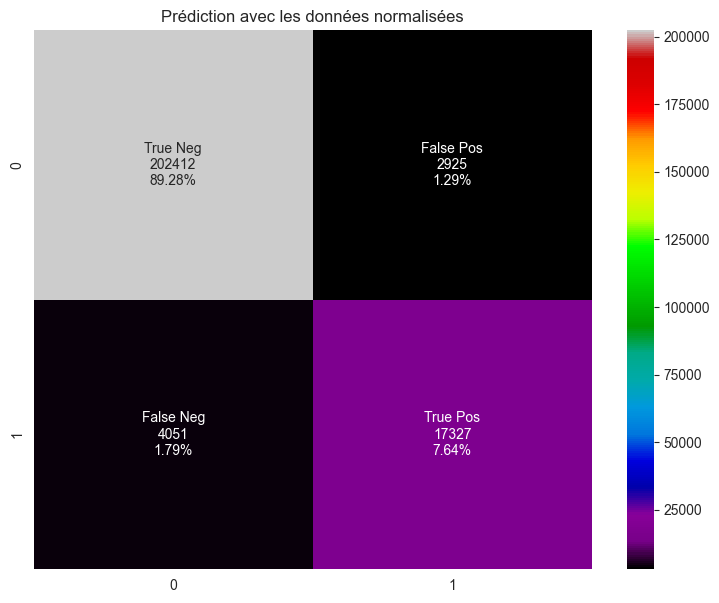

In [62]:
plot_confusion_matrix(cf_matrix)

In [32]:
test_path =  'evaluation/'
test_mask_path = 'sample/'
#test_path =  '/tmp/kaggledata/solafue_solars/train/s2_image/'
#test_mask_path = '/tmp/kaggledata/solafue_solars/train/mask/'

masks = glob.glob(f'{test_mask_path}/*')
tests = glob.glob(f'{test_path}/*')
masks.sort()
tests.sort()


In [33]:
import os
if not os.path.isdir('output'):
    os.mkdir('output')

In [34]:



for i, (m, t) in tqdm(enumerate(zip(masks, tests))):

    basename = os.path.basename(m)
    output_file = f'output_f1/{basename}'

    img = tifffile.imread(t).astype(np.float)
    mask = tifffile.imread(m).astype(np.float)
    img = img.reshape(-1, 12)

    img = pd.DataFrame(data=img, columns= ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11','B12'])

    #img = img[['B1', 'B2' ,'B6', 'B8', 'B9', 'B10']]

    img = scaler.transform(img)

    shape_mask = mask.shape

    pred = optimal_mask_model.predict_proba(img)

    pred_mask = np.argmax(pred, axis=1).astype(np.uint8)
    pred_mask = pred_mask.reshape(shape_mask[0], shape_mask[1])

    tifffile.imwrite(output_file, pred_mask)


2066it [00:13, 149.72it/s]


In [35]:
import shutil
shutil.make_archive('output_xgb_optuna_f1', 'zip', 'output_f1')

'/Users/ceyhun/XDARRAY_WORKING_FOLDER/output_xgb_optuna_f1.zip'